In [1]:
import os
root = os.path.join('..', '..')

In [2]:
import sys
sys.path.append(root)

In [3]:
import dataclasses
from abc import ABC, abstractmethod
from typing import Any, List, Literal, Optional, Tuple

import torch

from utils.fig import Axes, Figure

# Global Setting

In [4]:
Figure.set_seaborn_theme()
Figure.set_tex()
Figure.set_high_dpi()

# Data Utils

In [5]:
def load_acc(
    in_dim: int,
    hidden_dim: int,
    n_sample: int,
    n_noise_sample: int,
    norm: Literal['L0', 'L2', 'Linf'],
    mode: Literal['uniform', 'gauss'],
    perturbation_constraint: float,
    seed: int,
) -> Tuple[float, float]:
    fname = f'{in_dim}_{hidden_dim}_{n_sample}_{n_noise_sample}' + \
            f'_{norm}_{mode}_{perturbation_constraint}_{seed}'
    path = os.path.join(root, 'artificial', fname)
    d = torch.load(path, map_location='cpu')
    return d['adv_acc_for_natural'].item(), d['noise_acc_for_natural'].item()

# Figure Utils

## Superclass

In [6]:
class EmbedGraphIntoAxes(ABC):
    ax: Axes
    variables: Any
    xlabel: str
    use_comma_in_xticks: bool = True

    @abstractmethod
    def _load_acc(self, var: Any) -> Tuple[float, float]:
        pass

    def _append_var_to_x(self, var: Any, x: List[float]) -> None:
        x.append(var)

    def __call__(self) -> None:
        x, adv_y, noise_y = [], [], []
        for var in self.variables:
            self._append_var_to_x(var, x)
            adv_acc, noise_acc = self._load_acc(var)
            adv_y.append(adv_acc)
            noise_y.append(noise_acc)
            
        self.ax.line(x, adv_y, label='Adversarial', linewidth=2, marker='o')
        self.ax.line(x, noise_y, label='Noise', linewidth=2, marker='X', linestyle='--')
        self.ax.set_xlabel(self.xlabel)
        self.ax.set_ylabel('Accuracy')
        self.ax.set_yticks([0.5, 0.75, 1.0])
        self.ax.set_ylim(0.4, 1.05)
        if self.use_comma_in_xticks:
            self.ax.set_xticks_comma()

## Input Dimension Axes

In [7]:
@dataclasses.dataclass
class InputDimensionAxes(EmbedGraphIntoAxes):
    ax: Axes
    in_dims: Tuple[int, ...]
    hidden_dim: int
    n_sample: int
    n_noise_sample: int
    norm: Literal['L0', 'L2', 'Linf']
    mode: Literal['uniform', 'gauss']
    perturbation_constraints: Tuple[float, ...]
    seed: int
    xlabel: str = r'Input dimension $d$'

    def __post_init__(self) -> None:
        assert len(self.in_dims) == len(self.perturbation_constraints)
        self.variables = [(i, j) for i, j in zip(self.in_dims, self.perturbation_constraints)]

    def _load_acc(self, var: Tuple[int, float]) -> Tuple[float, float]:
        return load_acc(var[0], self.hidden_dim, self.n_sample, self.n_noise_sample, 
                        self.norm, self.mode, var[1], self.seed)
    
    def _append_var_to_x(self, var: Tuple[int, float], x: List[int]) -> None:
        x.append(var[0])

## Natural Sample Axes

In [8]:
@dataclasses.dataclass
class NaturalSampleAxes(EmbedGraphIntoAxes):
    ax: Axes
    in_dim: int
    hidden_dim: int
    n_samples: Tuple[int, ...]
    n_noise_sample: int
    norm: Literal['L0', 'L2', 'Linf']
    mode: Literal['uniform', 'gauss']
    perturbation_constraint: float
    seed: int
    xlabel: str = r'Natural sample $N$'

    def __post_init__(self) -> None:
        self.variables = self.n_samples

    def _load_acc(self, var: int) -> Tuple[float, float]:
        return load_acc(self.in_dim, self.hidden_dim, var, self.n_noise_sample, 
                        self.norm, self.mode, self.perturbation_constraint, self.seed)            

## Noise Sample Axes

In [9]:
@dataclasses.dataclass
class NoiseSampleAxes(EmbedGraphIntoAxes):
    ax: Axes
    in_dim: int
    hidden_dim: int
    n_sample: int
    n_noise_samples: Tuple[int, ...]
    norm: Literal['L0', 'L2', 'Linf']
    mode: Literal['uniform', 'gauss']
    perturbation_constraint: float
    seed: int
    xlabel: str = r'(Adversarial) noise sample $N^{\mathrm{adv}}$'

    def __post_init__(self) -> None:
        self.variables = self.n_noise_samples

    def _load_acc(self, var: int) -> Tuple[float, float]:
        return load_acc(self.in_dim, self.hidden_dim, self.n_sample, var, 
                        self.norm, self.mode, self.perturbation_constraint, self.seed)            

## Perturbation Constraint Axes

In [10]:
@dataclasses.dataclass
class PerturbationConstraintAxes(EmbedGraphIntoAxes):
    ax: Axes
    in_dim: int
    hidden_dim: int
    n_sample: int
    n_noise_samples: int
    norm: Literal['L0', 'L2', 'Linf']
    mode: Literal['uniform', 'gauss']
    perturbation_constraints: Tuple[float, ...]
    seed: int
    xlabel: Optional[str] = None

    def __post_init__(self) -> None:
        if self.xlabel is None:
            if self.norm in ['L2', 'Linf']:
                self.xlabel = r'Perturbation constraint $\epsilon$'
            else:
                self.xlabel = r'Modified pixel ratio $d_\delta/d$'
        self.variables = self.perturbation_constraints
        self.use_comma_in_xticks = False

    def _load_acc(self, var: int) -> Tuple[float, float]:
        return load_acc(self.in_dim, self.hidden_dim, self.n_sample, self.n_noise_samples, 
                        self.norm, self.mode, var, self.seed)            

## Two Axes

In [11]:
def two_axes(
    in_dim: int,
    in_dims: Tuple[int, ...],
    perturbation_constraints_along_with_in_dims: Tuple[float, ...],
    hidden_dim: int,
    n_sample: int,
    n_noise_sample: int,
    n_noise_samples: Tuple[int, ...],
    norm: Literal['L0', 'L2', 'Linf'],
    mode: Literal['uniform', 'gauss'],
    perturbation_constraint: float,
    seed: int,
) -> None:
    Figure.set_font_scale(0.8)
    f = Figure(1, 2, (6, 1.5))

    InputDimensionAxes(f.axes[0][0], in_dims, hidden_dim, n_sample, n_noise_sample, 
                       norm, mode, perturbation_constraints_along_with_in_dims, seed)()
    f.axes[0][0].remove_legend()
    
    NoiseSampleAxes(f.axes[0][1], in_dim, hidden_dim, n_sample, n_noise_samples, 
                    norm, mode, perturbation_constraint, seed)()

    f.save(root, 'figs', f'artificial_graph_{norm}_{mode}_two.pdf')
    f.show()
    f.close()

## All Axes

In [12]:
def all_axes(
    in_dim: int,
    in_dims: Tuple[int, ...],
    perturbation_constraints_along_with_in_dims: Tuple[float, ...],
    hidden_dim: int,
    n_sample: int,
    n_samples: Tuple[int, ...],
    n_noise_sample: int,
    n_noise_samples: Tuple[int, ...],
    norm: Literal['L0', 'L2', 'Linf'],
    mode: Literal['uniform', 'gauss'],
    perturbation_constraint: float,
    perturbation_constraints: Tuple[float, ...],
    seed: int,
) -> None:
    Figure.set_font_scale(0.8)
    f = Figure(2, 2, (6, 3))

    InputDimensionAxes(f.axes[0][0], in_dims, hidden_dim, n_sample, n_noise_sample,
                       norm, mode, perturbation_constraints_along_with_in_dims, seed)()
    f.axes[0][0].remove_legend()
    
    NoiseSampleAxes(f.axes[0][1], in_dim, hidden_dim, n_sample, n_noise_samples, 
                    norm, mode, perturbation_constraint, seed)()

    NaturalSampleAxes(f.axes[1][0], in_dim, hidden_dim, n_samples, n_noise_sample, 
                      norm, mode, perturbation_constraint, seed)()
    f.axes[1][0].remove_legend()
    
    PerturbationConstraintAxes(f.axes[1][1], in_dim, hidden_dim, n_sample, n_noise_sample, 
                               norm, mode, perturbation_constraints, seed)()
    f.axes[1][1].remove_legend()

    f.save(root, 'figs', f'artificial_graphs_{norm}_{mode}.pdf')
    f.show()
    f.close()

# L2 / Uniform

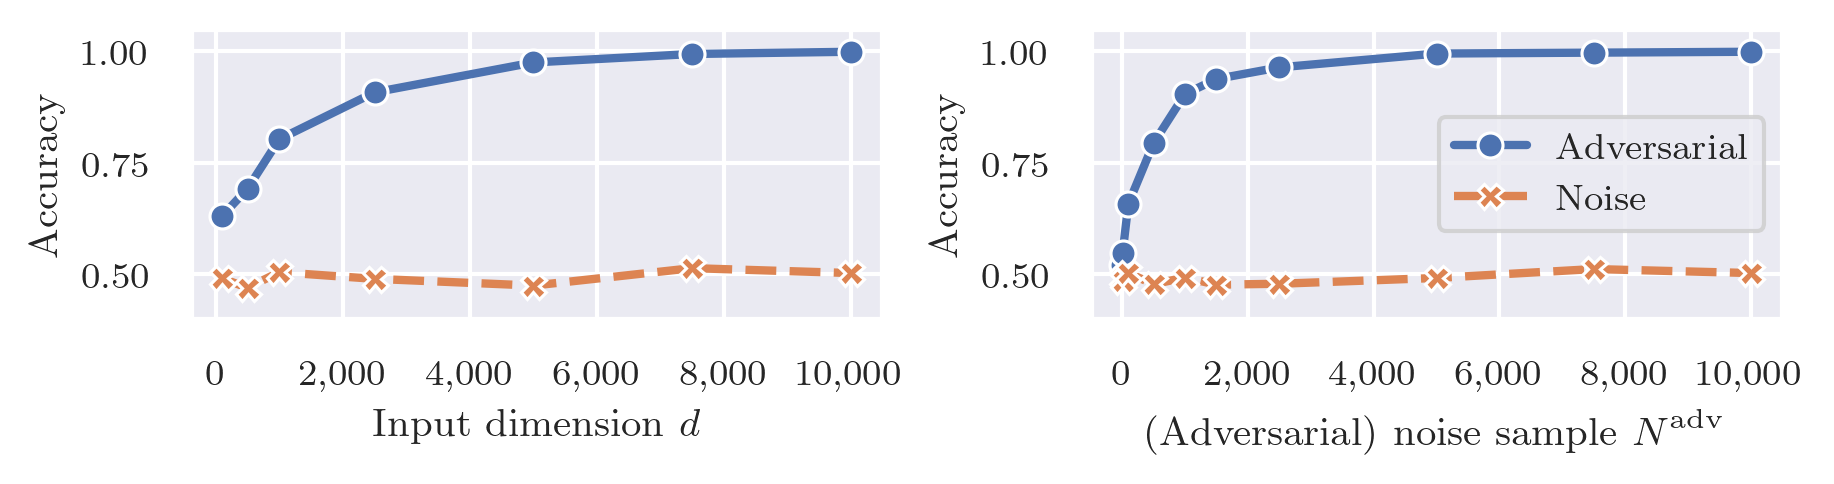

In [13]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.078, 0.17, 0.24, 0.39, 0.55, 0.67, 0.78)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'L2'
mode = 'uniform'
perturbation_constraint = 0.78
perturbation_constraints = (0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.78)
seed = 5

two_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    seed,
)

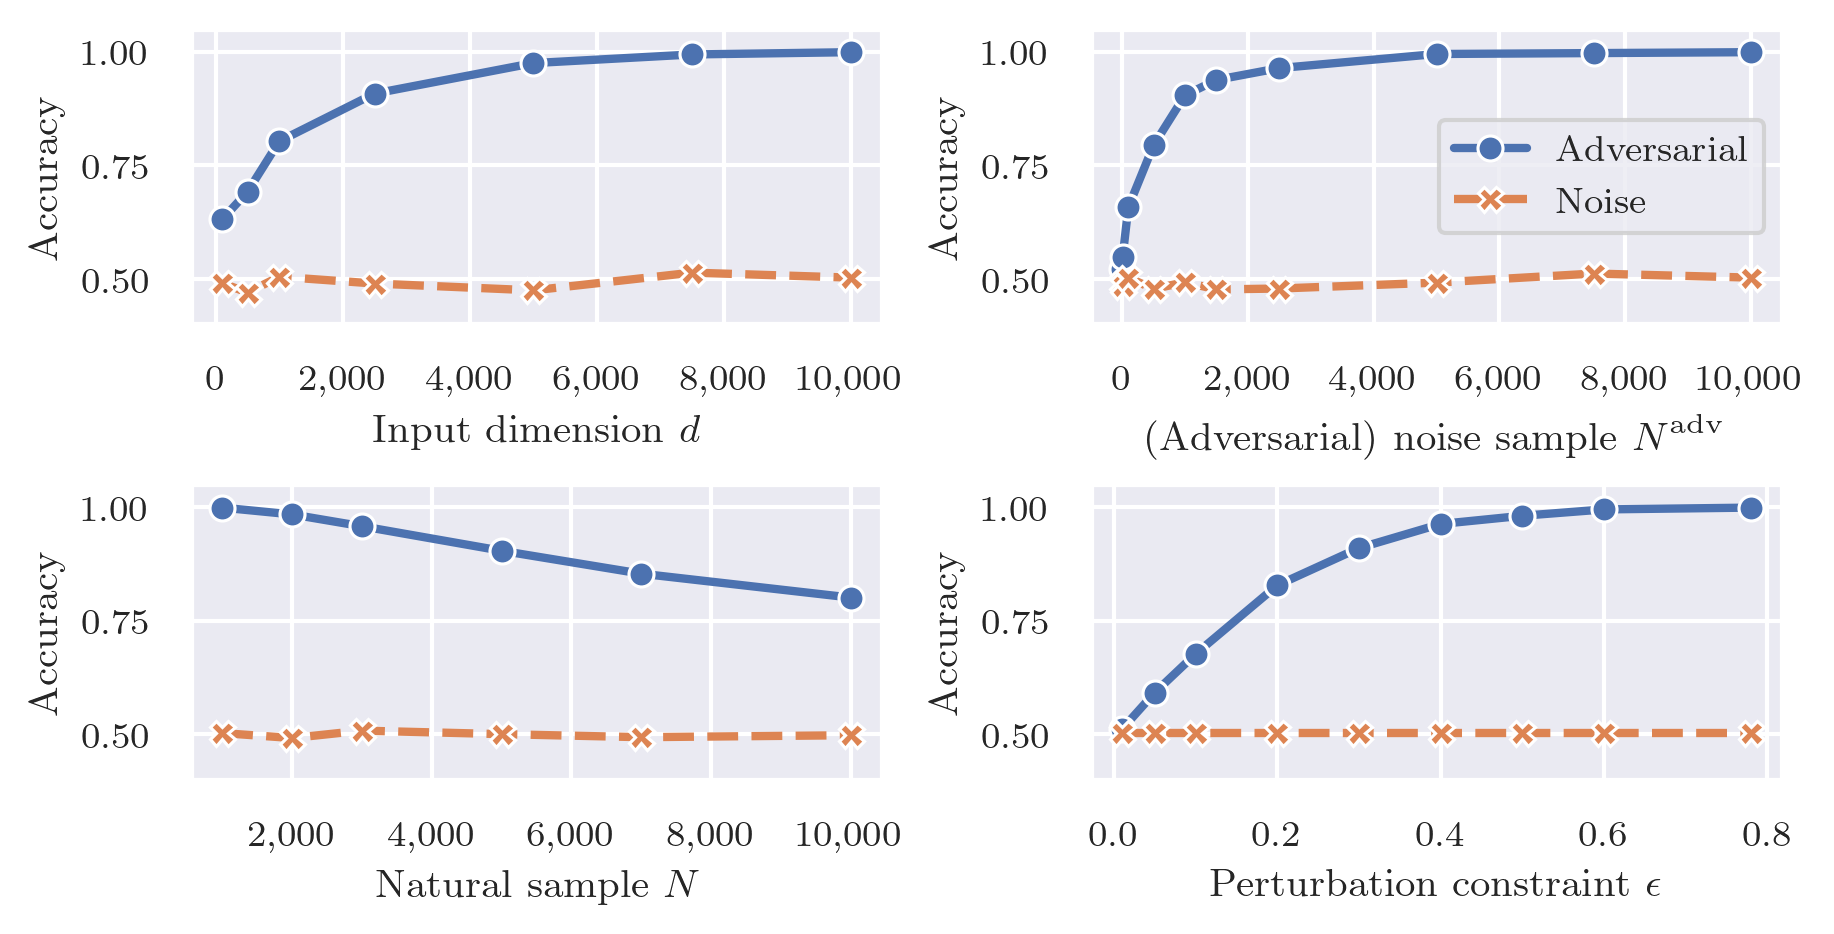

In [14]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.078, 0.17, 0.24, 0.39, 0.55, 0.67, 0.78)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'L2'
mode = 'uniform'
perturbation_constraint = 0.78
perturbation_constraints = (0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.78)
seed = 5

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)

# L2 / Gauss

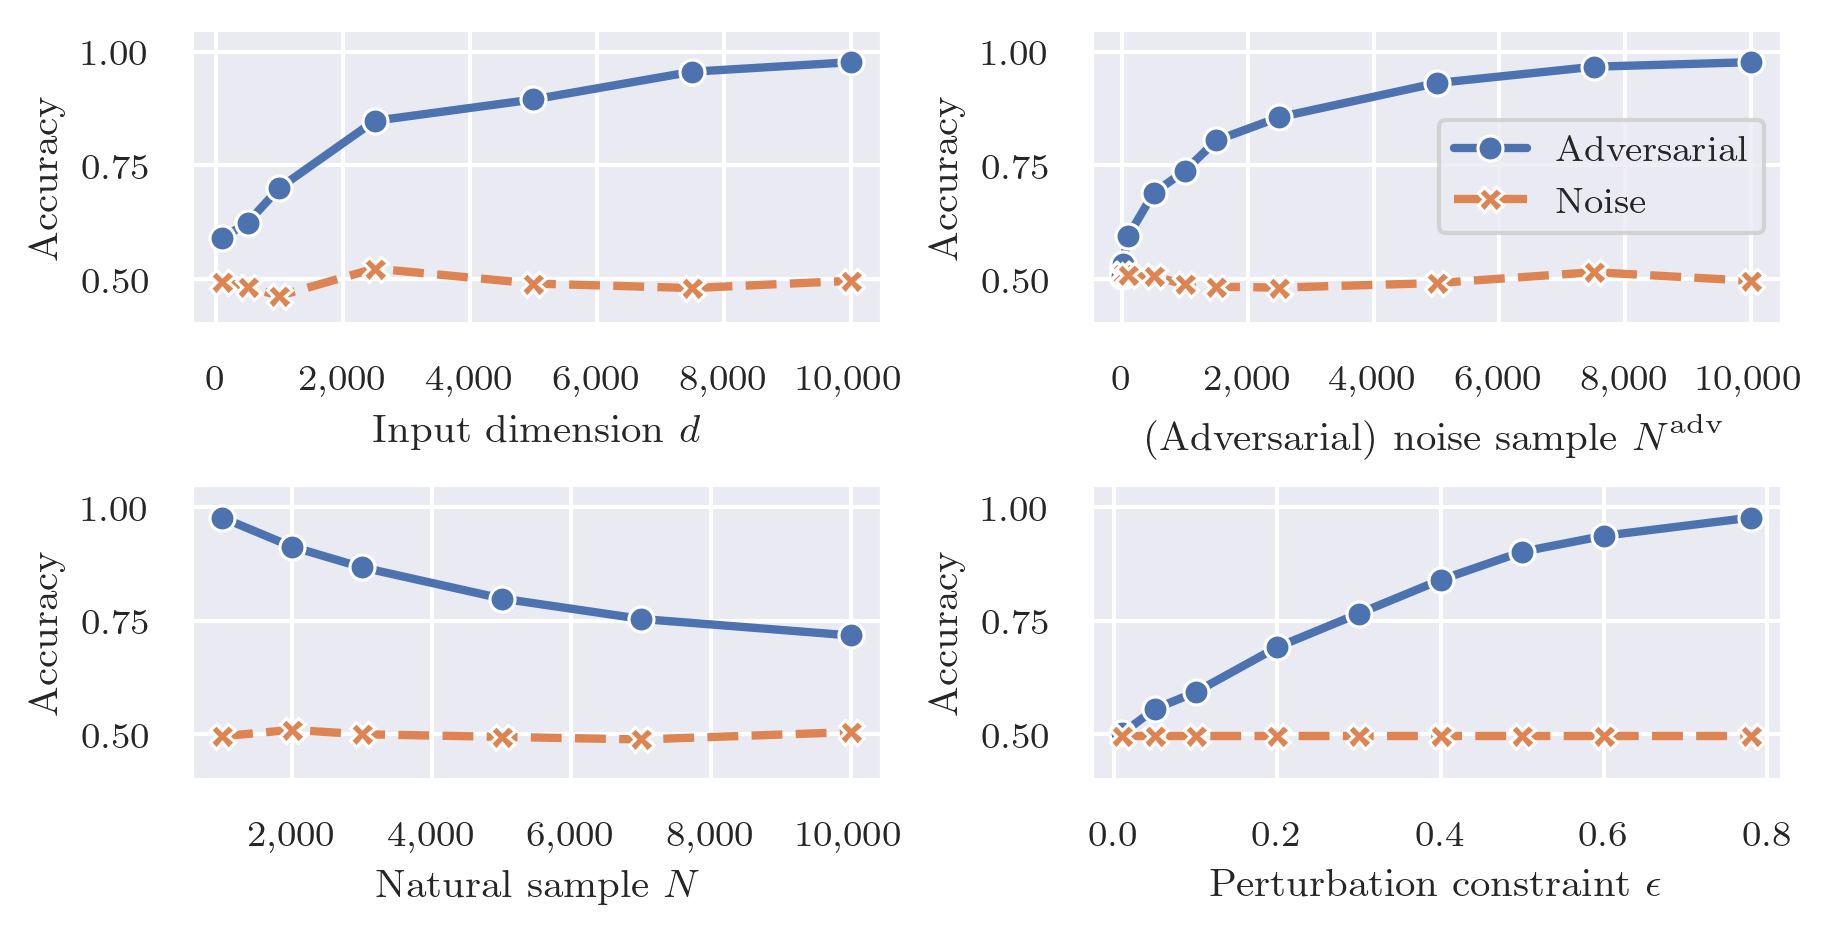

In [15]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.078, 0.17, 0.24, 0.39, 0.55, 0.67, 0.78)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'L2'
mode = 'gauss'
perturbation_constraint = 0.78
perturbation_constraints = (0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.78)
seed = 2

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)

# L0 / Uniform

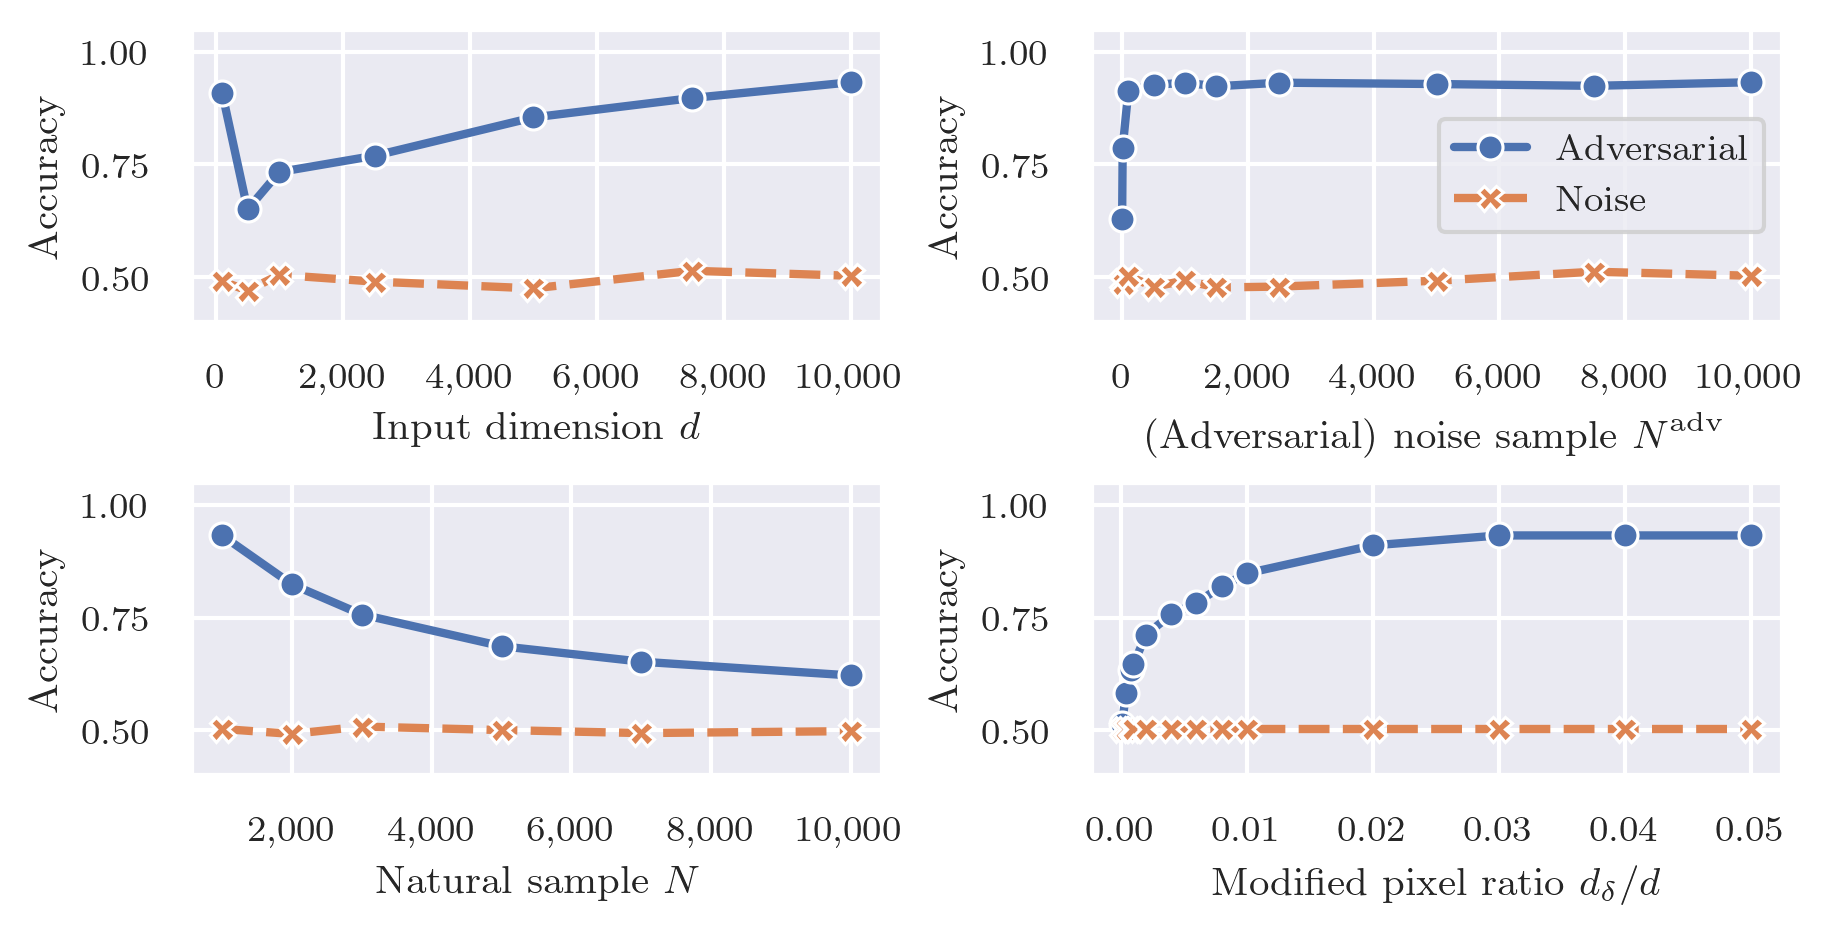

In [16]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'L0'
mode = 'uniform'
perturbation_constraint = 0.05
perturbation_constraints = (0.0001, 0.0004, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05)
seed = 5

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)

# L0 / Gauss

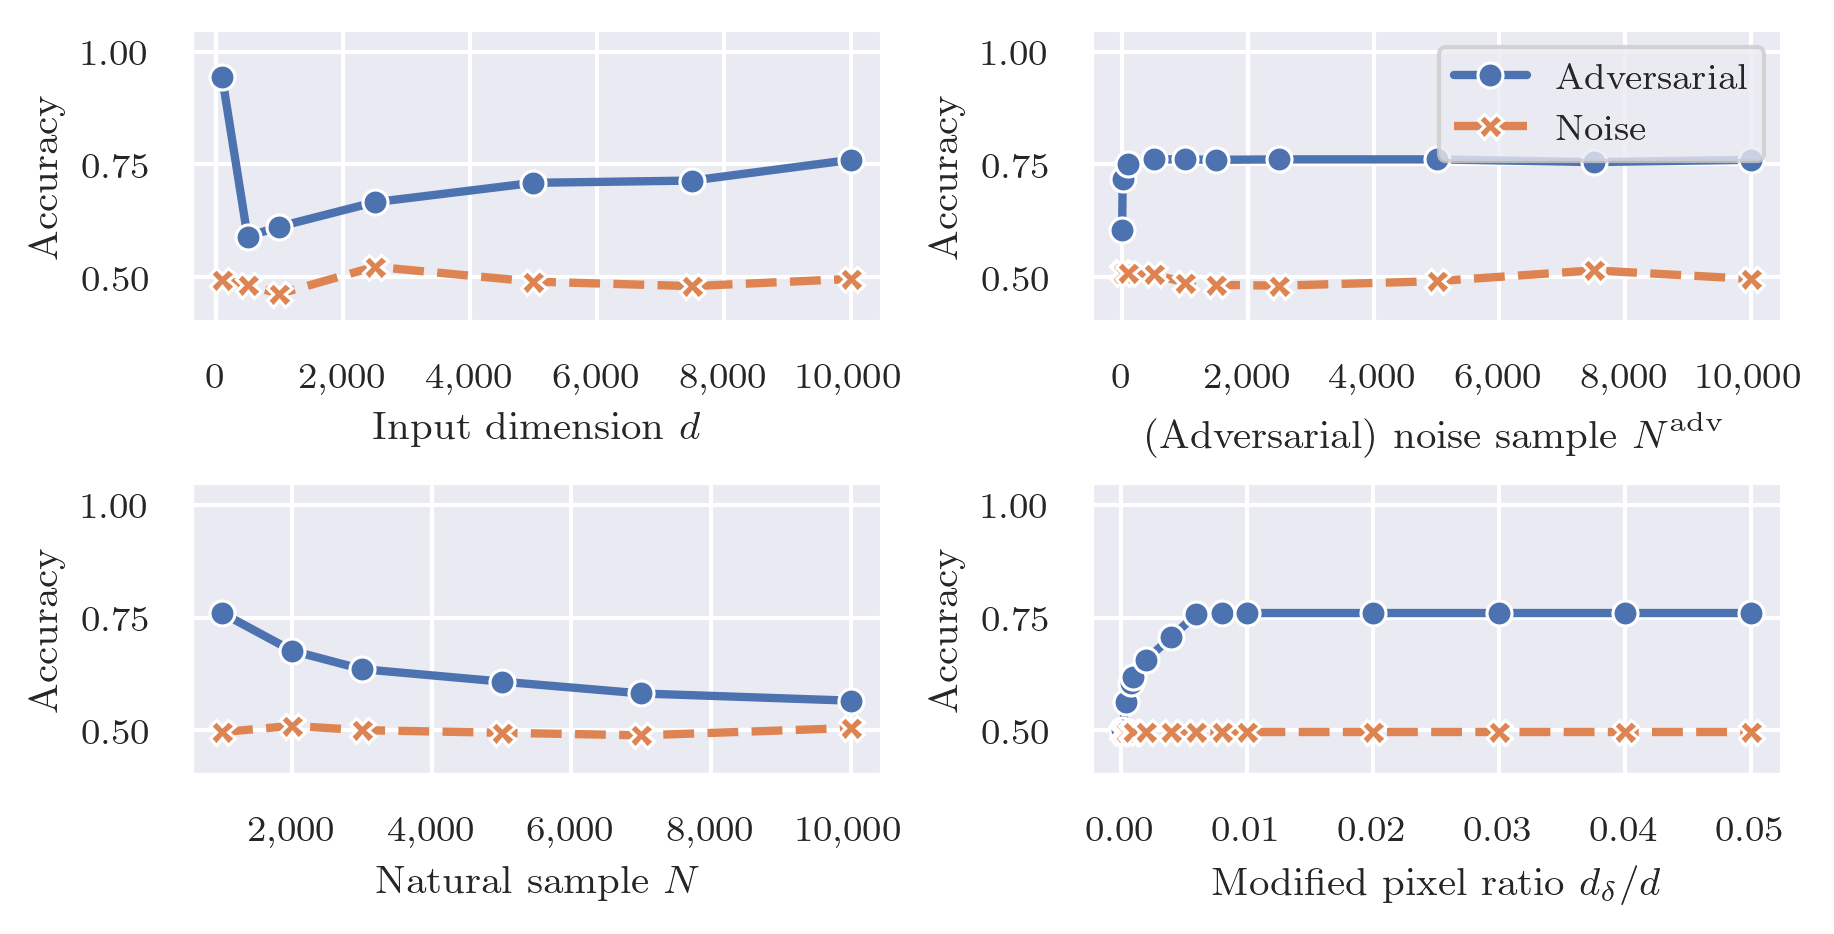

In [17]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'L0'
mode = 'gauss'
perturbation_constraint = 0.05
perturbation_constraints = (0.0001, 0.0004, 0.0008, 0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05)
seed = 2

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)

# Linf / Uniform

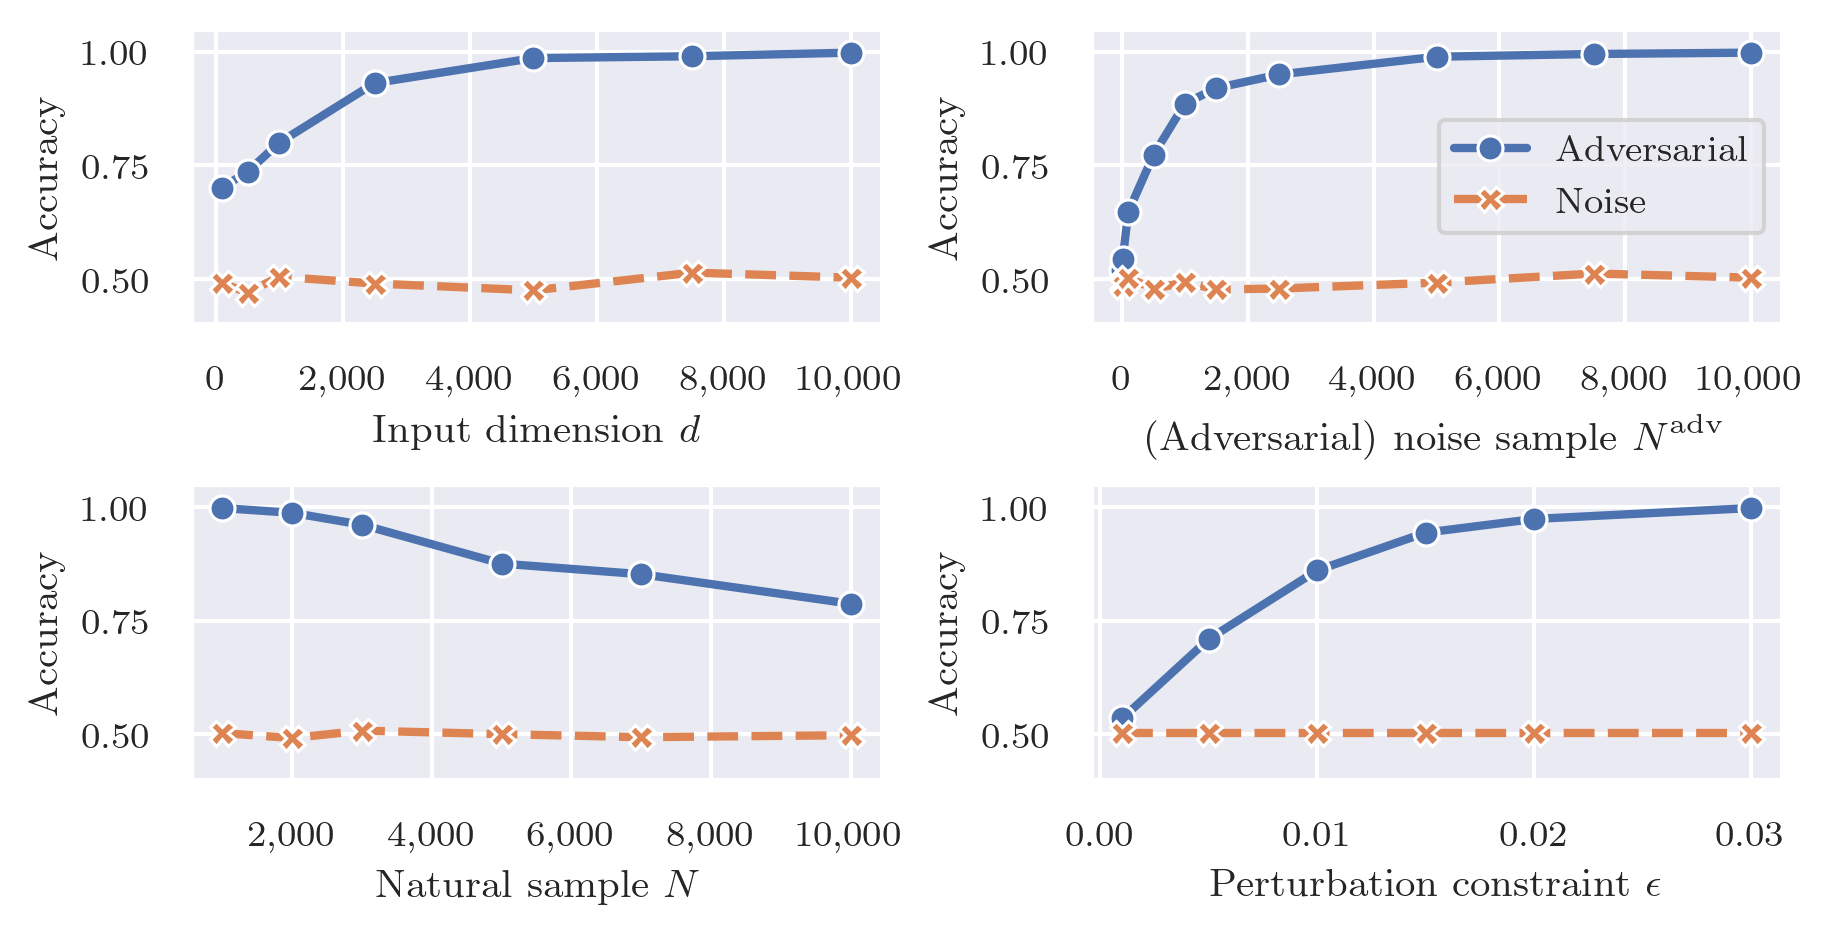

In [18]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'Linf'
mode = 'uniform'
perturbation_constraint = 0.03
perturbation_constraints = (0.001, 0.005, 0.01, 0.015, 0.02, 0.03)
seed = 5

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)

# Linf / Gauss

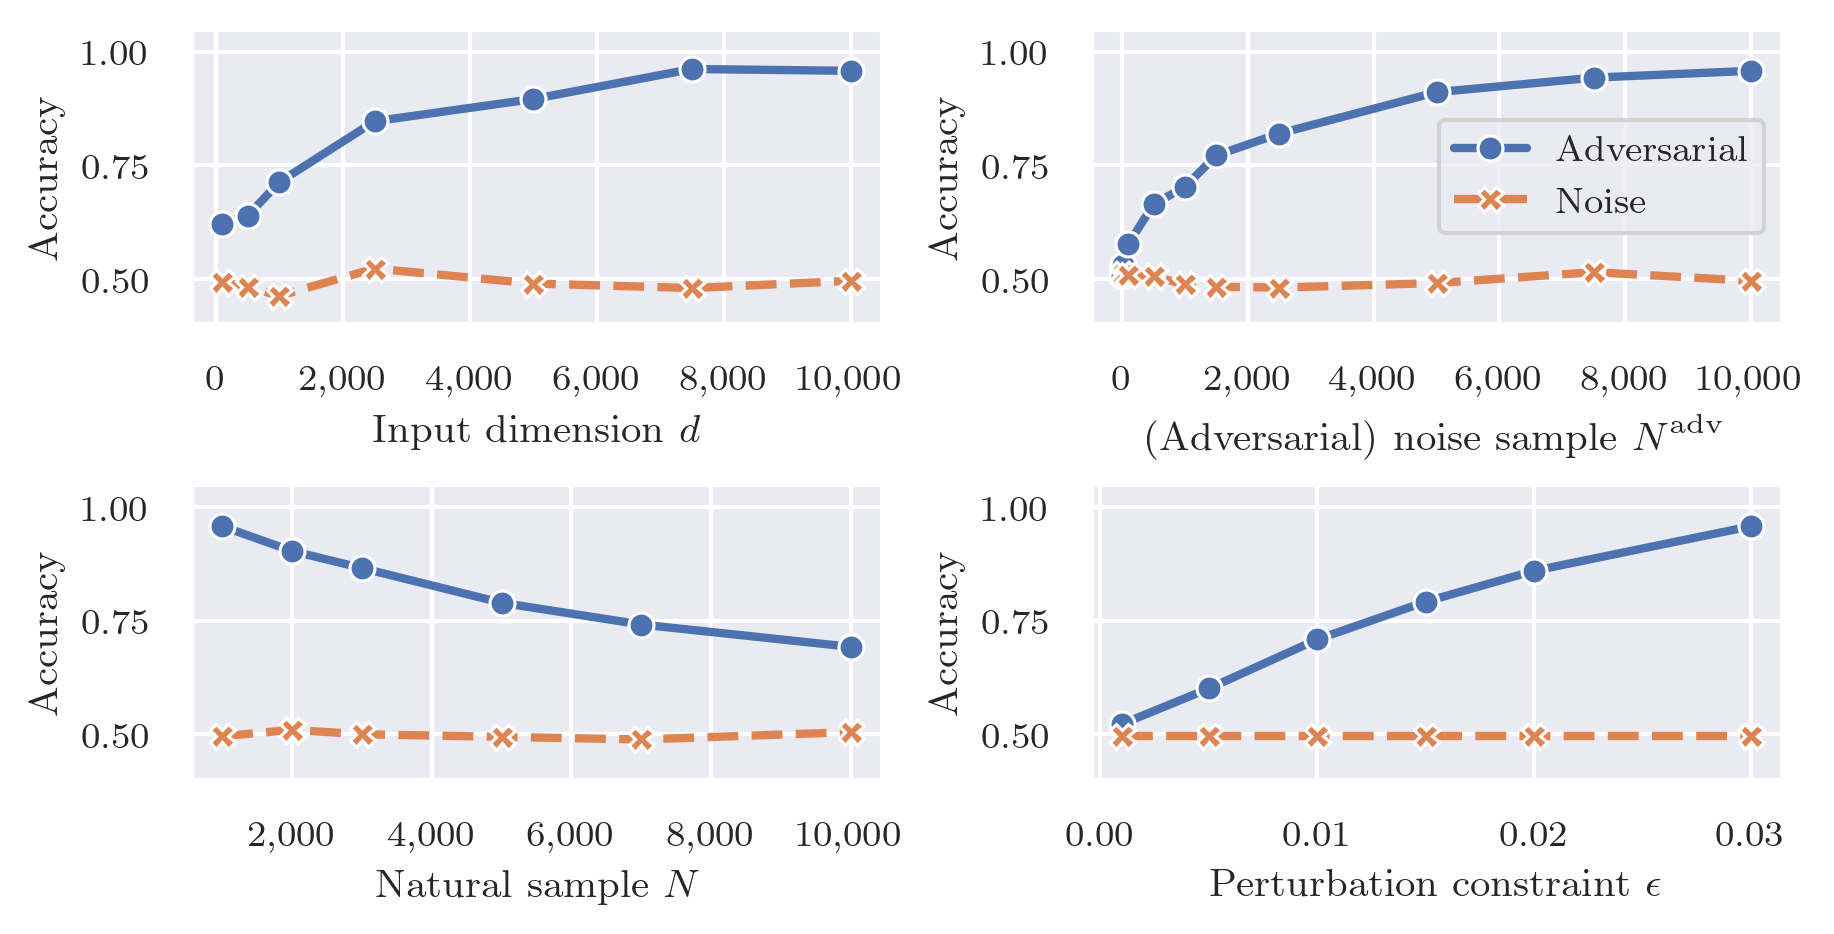

In [19]:
in_dim = 10000
in_dims = (100, 500, 1000, 2500, 5000, 7500, 10000)
perturbation_constraints_along_with_in_dims = (0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03)
hidden_dim = 1000
n_sample = 1000
n_samples = (1000, 2000, 3000, 5000, 7000, 10000)
n_noise_sample = 10000
n_noise_samples = (1, 10, 100, 500, 1000, 1500, 2500, 5000, 7500, 10000)
norm = 'Linf'
mode = 'gauss'
perturbation_constraint = 0.03
perturbation_constraints = (0.001, 0.005, 0.01, 0.015, 0.02, 0.03)
seed = 2

all_axes(
    in_dim,
    in_dims,
    perturbation_constraints_along_with_in_dims,
    hidden_dim,
    n_sample,
    n_samples,
    n_noise_sample,
    n_noise_samples,
    norm,
    mode,
    perturbation_constraint,
    perturbation_constraints,
    seed,
)